This notebook adresseses a single machine scheduling problem. The objective studied is minimizing the sum of weighted completion times on a single "batching" machine. Batching machines can process simultaneously up to a specified number of the jobs of a particular family (type).  

Each job is associated with:

- proccesing time
- weight
- family (type)

The scheduling problem can be represented by 1| <em>batch, fmls</em> | $ \sum\limits_{j=1}^{n}w_𝑗C_j $  . This problem is known to be NP-hard. IBM ILOG CPLEX Optimization Studio includes solvers for both Mathematical and Constraint Programming. Constraint Programming is particularly efficient and useful to tackle detailed scheduling problems. By using docplex.cp python package, you can easily formulate and solve scheduling problems in python notebooks. Below is an example formulation with randomly generated sample data to provide a better understanding of the problem and the model.

In [1]:
nbrOfJobs = 10
jobs = [*range(0, nbrOfJobs)] 

In [2]:
#generate a job type and processing time for each job
import random
nbrOfJobTypes = 3   #job families
types = [*range(0, nbrOfJobTypes)] 
minProcessingTime=10
maxProcessingTime=40
jobTypeProcessingTimes = [random.randint(minProcessingTime, maxProcessingTime) for t in types]
jobTypes = [random.randint(0, nbrOfJobTypes-1) for j in jobs]
processingTimes = [jobTypeProcessingTimes[jobTypes[j]] for j in jobs]

In [3]:
#generate weight for each job
minWeight=1
maxWeight=5
weights = [random.randint(minWeight, maxWeight) for j in jobs]

In [4]:
import pandas as pd
JobsTable = pd.DataFrame(columns=['job', 'type','processing_time', 'weight'])
for j in jobs:
    JobsTable=JobsTable.append({'job': j,'type': jobTypes[j],'processing_time':processingTimes[j],'weight':weights[j]}, ignore_index=True)
print(JobsTable)

  job type processing_time weight
0   0    2              38      3
1   1    0              24      1
2   2    0              24      2
3   3    0              24      4
4   4    2              38      5
5   5    0              24      4
6   6    1              33      2
7   7    1              33      3
8   8    0              24      4
9   9    1              33      1


In [5]:
#define capacity of batching machine
batchingCapacity=2

In [6]:
from docplex.cp.model import *
mdl = CpoModel(name='singleMachineSchedulingBatching') 

In [7]:
# define production processing interval of each job at each machine
processing_itv_vars = [mdl.interval_var(size=processingTimes[j], name="interval_job{}".format(j)) for j in jobs] 
for j in jobs:
    print(processing_itv_vars[j])

interval_job0 = intervalVar(size=38)
interval_job1 = intervalVar(size=24)
interval_job2 = intervalVar(size=24)
interval_job3 = intervalVar(size=24)
interval_job4 = intervalVar(size=38)
interval_job5 = intervalVar(size=24)
interval_job6 = intervalVar(size=33)
interval_job7 = intervalVar(size=33)
interval_job8 = intervalVar(size=24)
interval_job9 = intervalVar(size=33)


In [8]:
s = mdl.state_function() 
jobs_atAtime = sum([pulse(processing_itv_vars[j],1) for j in jobs]) #to be used in batching constraints 

In [9]:
#minimize total weighted completion time 
objective = mdl.sum(mdl.end_of(processing_itv_vars[j])*weights[j] for j in jobs)
mdl.add(mdl.minimize(objective)) 

In [10]:
#capacity cannot be exceeded
mdl.add(jobs_atAtime <= batchingCapacity) 

In [11]:
#only jobs of the same type can be processed simultaneously 
for j in jobs:
    mdl.add(mdl.always_equal(s, processing_itv_vars[j], jobTypes[j]))

In [12]:
msol= mdl.solve(log_output=True,TimeLimit=60)

In [13]:
print("Solution: ")
msol.print_solution()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 11, variables: integer: 0, interval: 10, sequence: 0
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 32.14 sec
-------------------------------------------------------------------------------
Objective values: (2082,), bounds: (2082,), gaps: (0,)
interval_job0: (start=48, end=86, size=38, length=38)
interval_job1: (start=119, end=143, size=24, length=24)
interval_job2: (start=24, end=48, size=24, length=24)
interval_job3: (start=24, end=48, size=24, length=24)
interval_job4: (start=48, end=86, size=38, length=38)
interval_job5: (start=0, end=24, size=24, length=24)
interval_job6: (start=86, end=119, size=33, length=33)
interval_job7: (start=86, end=119, size=33, length=33)
interval_job8: (start=0, end=24, size=24, length=24)
interval_job9: (start=143, end=176, size=33, length=33)


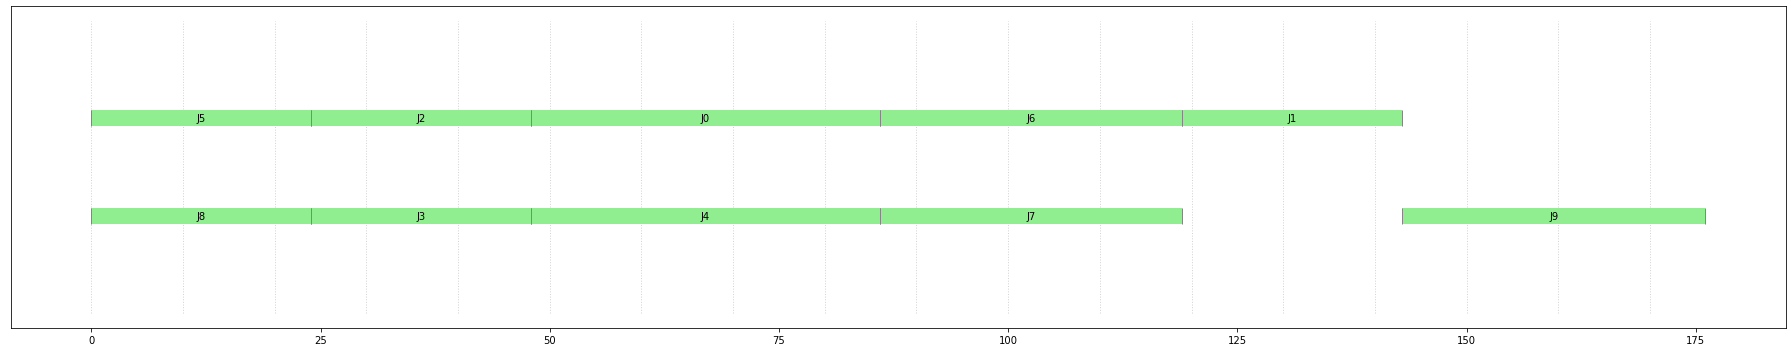

In [14]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5
if msol and visu.is_visu_enabled():
    visu.timeline("Solution Schedule", 0, 100)
    for j in jobs:
        itv = msol.get_var_solution(processing_itv_vars[j])
        if itv.is_present():
            visu.interval(itv,'lightgreen','J' + str(j))
    visu.show()